<a href="https://colab.research.google.com/github/thihanaung-thnn/python_projects/blob/main/pre_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install imblearn

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict
from imblearn.over_sampling import SMOTENC 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# Importing and data preprocessing

In [104]:
data = pd.read_csv("/content/drive/MyDrive/Programming Projects/Python/diabetes/diabetes_dataset__2019.csv")
data

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic
0,50-59,Male,no,yes,one hr or more,39.0,no,no,8,6,no,occasionally,sometimes,high,0.0,0,not much,no
1,50-59,Male,no,yes,less than half an hr,28.0,no,no,8,6,yes,very often,sometimes,normal,0.0,0,not much,no
2,40-49,Male,no,no,one hr or more,24.0,no,no,6,6,no,occasionally,sometimes,normal,0.0,0,not much,no
3,50-59,Male,no,no,one hr or more,23.0,no,no,8,6,no,occasionally,sometimes,normal,0.0,0,not much,no
4,40-49,Male,no,no,less than half an hr,27.0,no,no,8,8,no,occasionally,sometimes,normal,0.0,0,not much,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,less than 40,Male,yes,no,more than half an hr,25.0,no,no,8,6,no,often,sometimes,normal,0.0,0,not much,yes
948,60 or older,Male,yes,yes,more than half an hr,27.0,no,no,6,5,yes,occasionally,sometimes,high,0.0,0,quite often,yes
949,60 or older,Male,no,yes,none,23.0,no,no,6,5,yes,occasionally,sometimes,high,0.0,0,not much,no
950,60 or older,Male,no,yes,less than half an hr,27.0,no,yes,6,5,yes,occasionally,very often,high,0.0,0,not much,no


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               952 non-null    object 
 1   Gender            952 non-null    object 
 2   Family_Diabetes   952 non-null    object 
 3   highBP            952 non-null    object 
 4   PhysicallyActive  952 non-null    object 
 5   BMI               948 non-null    float64
 6   Smoking           952 non-null    object 
 7   Alcohol           952 non-null    object 
 8   Sleep             952 non-null    int64  
 9   SoundSleep        952 non-null    int64  
 10  RegularMedicine   952 non-null    object 
 11  JunkFood          952 non-null    object 
 12  Stress            952 non-null    object 
 13  BPLevel           952 non-null    object 
 14  Pregancies        910 non-null    float64
 15  Pdiabetes         951 non-null    object 
 16  UriationFreq      952 non-null    object 
 1

In [7]:
for col in data.columns:
    print(col)
    print(data[col].value_counts())
    print(f'-'*20)

Age
less than 40    488
40-49           164
50-59           156
60 or older     144
Name: Age, dtype: int64
--------------------
Gender
Male      580
Female    372
Name: Gender, dtype: int64
--------------------
Family_Diabetes
no     498
yes    454
Name: Family_Diabetes, dtype: int64
--------------------
highBP
no     724
yes    228
Name: highBP, dtype: int64
--------------------
PhysicallyActive
less than half an hr    336
more than half an hr    272
one hr or more          212
none                    132
Name: PhysicallyActive, dtype: int64
--------------------
BMI
24.0    111
21.0     88
23.0     76
28.0     71
26.0     66
33.0     64
27.0     63
22.0     58
20.0     48
19.0     36
25.0     34
30.0     33
18.0     32
29.0     28
38.0     28
36.0     20
31.0     16
17.0     16
32.0     16
34.0     12
35.0     12
15.0      8
39.0      4
40.0      4
42.0      3
45.0      1
Name: BMI, dtype: int64
--------------------
Smoking
no     844
yes    108
Name: Smoking, dtype: int64
----------

In [8]:
data['RegularMedicine'].replace('o','no', inplace=True)
data['BPLevel'] = data['BPLevel'].str.lower().str.strip()
data['Pdiabetes'].replace('0', 'no', inplace=True)
data['Diabetic'] = data['Diabetic'].str.strip()

In [9]:
# there is nan value at pregancies column where gender is male 
# if these values are replaced with 0, there's only 26 values, so all nan values will be replaced with 0. 
data[data['Gender']=='Male']['Pregancies'].isna().sum()

16

In [10]:
data['Pregancies'].replace(np.nan, 0, inplace=True)
# will drop all na's 
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 951
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               947 non-null    object 
 1   Gender            947 non-null    object 
 2   Family_Diabetes   947 non-null    object 
 3   highBP            947 non-null    object 
 4   PhysicallyActive  947 non-null    object 
 5   BMI               947 non-null    float64
 6   Smoking           947 non-null    object 
 7   Alcohol           947 non-null    object 
 8   Sleep             947 non-null    int64  
 9   SoundSleep        947 non-null    int64  
 10  RegularMedicine   947 non-null    object 
 11  JunkFood          947 non-null    object 
 12  Stress            947 non-null    object 
 13  BPLevel           947 non-null    object 
 14  Pregancies        947 non-null    float64
 15  Pdiabetes         947 non-null    object 
 16  UriationFreq      947 non-null    object 
 1

In [11]:
num_cols = ['BMI', 'Sleep', 'SoundSleep', 'Pregancies']
category_cols = list(set(data.columns).difference(set(num_cols)))

data_clean = pd.DataFrame()
for col in num_cols: 
    data_clean[col] = data[col].astype('int')

for col in category_cols: 
    data_clean[col] = data[col].astype('category')

# categorical variables in pandas is a little tricky. 
# I want to order the categorical variables according to the risks. 
data_clean['Age'] = pd.Categorical(data['Age'], ordered=True, 
                                   categories=['less than 40', '40-49', '50-59', '60 or older'])
data_clean['PhysicallyActive'] = pd.Categorical(data['PhysicallyActive'], ordered=True, 
                                                categories=['one hr or more', 'more than half an hr', 'less than half an hr', 'none'])
data_clean['JunkFood'] = pd.Categorical(data['JunkFood'], ordered=True, categories=['occasionally', 'often', 'very often', 'always'])
data_clean['BPLevel'] = pd.Categorical(data['BPLevel'], ordered=True, 
                                       categories=['low', 'normal', 'high'])
data_clean['Stress'] = pd.Categorical(data['Stress'], ordered=True, 
                                      categories=['not at all', 'sometimes', 'very often', 'always'])

# sklearn cannot map according to this order and so do it manually. 
category_mapping = {
    'Age':{'less than 40':0, '40-49':1, '50-59':2, '60 or older':3},
    'Family_Diabetes':{'no':0, 'yes':1},
    'Gender':{'Female':0, 'Male':1},
    'Smoking':{'no':0, 'yes':1},
    'Pdiabetes':{'no':0, 'yes':1},
    'RegularMedicine':{'no':0, 'yes':1},
    'PhysicallyActive':{'one hr or more':0, 'more than half an hr':1, 'less than half an hr':2, 'none':3},
    'JunkFood':{'occasionally':0, 'often':1, 'very often':2, 'always':3},
    'BPLevel':{'low':0, 'normal':1, 'high':2},
    'highBP':{'no':0, 'yes':1},
    'Alcohol':{'no':0, 'yes':1},
    'UriationFreq':{'not much':0, 'quite often':1},
    'Stress':{'not at all':0, 'sometimes':1, 'very often':2, 'always':3},
    'Diabetic':{'no':0, 'yes':1},
}

for col in category_cols:
    data_clean[col] = data_clean[col].map(category_mapping[col])

In [12]:
data_clean.head()

,BMI,Sleep,SoundSleep,Pregancies,Family_Diabetes,Smoking,Gender,BPLevel,Stress,PhysicallyActive,UriationFreq,Age,Alcohol,RegularMedicine,JunkFood,Pdiabetes,Diabetic,highBP
0,39,8,6,0,0,0,1,2,1,0,0,2,0,0,0,0,0,1
1,28,8,6,0,0,0,1,1,1,2,0,2,0,1,2,0,0,1
2,24,6,6,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0
3,23,8,6,0,0,0,1,1,1,0,0,2,0,0,0,0,0,0
4,27,8,8,0,0,0,1,1,1,2,0,1,0,0,0,0,0,0


In [13]:
data_clean['Diabetic'].value_counts()

0    682
1    265
Name: Diabetic, dtype: int64

In [14]:
# split the dataset for preventing data leakage

X = data_clean.drop('Diabetic', axis=1)
y = data_clean['Diabetic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [15]:
print(y_train.value_counts())
print(y_test.value_counts())

0    545
1    212
Name: Diabetic, dtype: int64
0    137
1     53
Name: Diabetic, dtype: int64


In [16]:

def smote_data(X, y):
    smotenc = SMOTENC(random_state = 123, categorical_features = list(range(4, 17)), n_jobs=-1)
    X_smote, y_smote = smotenc.fit_resample(X, y)
    return X_smote, y_smote 

X_train_smote, y_train_smote = smote_data(X_train, y_train)
X_test_smote, y_test_smote = smote_data(X_test, y_test)

In [17]:
print(y_train_smote.value_counts())
print(y_test_smote.value_counts())

1    545
0    545
Name: Diabetic, dtype: int64
1    137
0    137
Name: Diabetic, dtype: int64


# Model training 

In [18]:
def grid_search(X_tr, X_te, y_tr, y_te, model, params, scoring='recall'):
    gs = GridSearchCV(estimator = model, param_grid = params, scoring = scoring, n_jobs=-1, cv=3)
    gs.fit(X_tr, y_tr)
    y_pred = gs.predict(X_te)
    print(f"{model}")
    print(f"Best parameter      : {gs.best_params_}")
    print(f"Test Accuracy Score : {accuracy_score(y_te, y_pred)}")
    print(f"Train Accuracy Score: {accuracy_score(y_tr, gs.predict(X_tr))}")
    print(f"Recall score        : {recall_score(y_te, y_pred)}")
    print(f"Classification Report \n{'-'*30}\n {classification_report(y_te, y_pred)}")
    return gs.best_params_


## Logistic Regression

In [19]:
params = {
    'C' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
    'penalty' : ['l1', 'l2', 'elasticnet', 'none']
}
model = LogisticRegression(max_iter=500)
lr_best = grid_search(X_train_smote, X_test, y_train_smote, y_test, model, params, scoring='accuracy')


LogisticRegression(max_iter=500)
Best parameter      : {'C': 1e-05, 'penalty': 'none'}
Test Accuracy Score : 0.8473684210526315
Train Accuracy Score: 0.8834862385321101
Recall score        : 0.8867924528301887
Classification Report ---------
               precision    recall  f1-score   support

           0       0.95      0.83      0.89       137
           1       0.67      0.89      0.76        53

    accuracy                           0.85       190
   macro avg       0.81      0.86      0.83       190
weighted avg       0.87      0.85      0.85       190



## AdaBoost Classifier

In [20]:
ada = AdaBoostClassifier()
params = {
    'n_estimators' : [100,200, 300, 400],
    'learning_rate' : [0.0001, 0.001,0.1,1,10]
}
ada_best = grid_search(X_train_smote, X_test, y_train_smote, y_test, ada, params, scoring='accuracy')

AdaBoostClassifier()
Best parameter      : {'learning_rate': 0.1, 'n_estimators': 300}
Test Accuracy Score : 0.8473684210526315
Train Accuracy Score: 0.8926605504587156
Recall score        : 0.9056603773584906
Classification Report ---------
               precision    recall  f1-score   support

           0       0.96      0.82      0.89       137
           1       0.67      0.91      0.77        53

    accuracy                           0.85       190
   macro avg       0.81      0.87      0.83       190
weighted avg       0.88      0.85      0.85       190



## Random Forest Classifier

In [21]:
params = {
    'n_estimators':[100, 200, 300, 400, 500, 600],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20],
}
model = RandomForestClassifier(random_state=123)
rf_best = grid_search(X_train_smote, X_test, y_train_smote, y_test, model, params, scoring='accuracy')

RandomForestClassifier(random_state=123)
Best parameter      : {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}
Test Accuracy Score : 0.968421052631579
Train Accuracy Score: 0.9834862385321101
Recall score        : 0.9056603773584906
Classification Report ---------
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       137
           1       0.98      0.91      0.94        53

    accuracy                           0.97       190
   macro avg       0.97      0.95      0.96       190
weighted avg       0.97      0.97      0.97       190



## Support Vector Classifier

In [79]:
model = SVC(random_state=123)
params = {
    'C' : [0.001, 0.01, 0.1, 1, 10],
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' : [2, 3, 4, 5]
}
svc_best = grid_search(X_train_smote, X_test, y_train_smote, y_test, model, params, scoring='accuracy')


SVC(random_state=123)
Best parameter      : {'C': 10, 'degree': 4, 'kernel': 'poly'}
Test Accuracy Score : 0.8526315789473684
Train Accuracy Score: 0.9073394495412844
Recall score        : 0.8867924528301887
Classification Report ---------
               precision    recall  f1-score   support

           0       0.95      0.84      0.89       137
           1       0.68      0.89      0.77        53

    accuracy                           0.85       190
   macro avg       0.82      0.86      0.83       190
weighted avg       0.88      0.85      0.86       190



# Model Comparing

In [81]:
model_lr = LogisticRegression(C=lr_best['C'], penalty=lr_best['penalty'], random_state=123)
y_scores_lr = cross_val_predict(model_lr, X_train_smote, y_train_smote, cv=5, method='predict_proba')

model_ada = AdaBoostClassifier(n_estimators=ada_best['n_estimators'], learning_rate=ada_best['learning_rate'], random_state=123)
y_scores_ada = cross_val_predict(model_ada, X_train_smote, y_train_smote, cv=5, method='predict_proba')

model_rf = RandomForestClassifier(n_estimators=rf_best['n_estimators'], criterion=rf_best['criterion'], max_depth=rf_best['max_depth'], 
                                  random_state=123)
y_scores_rf = cross_val_predict(model_rf, X_train_smote, y_train_smote, cv=5, method='predict_proba')


model_svc = SVC(C=svc_best['C'], degree=svc_best['degree'], kernel=svc_best['kernel'], probability=True)
y_scores_svc = cross_val_predict(model_svc, X_train_smote, y_train_smote, cv=5, method='predict_proba')

y_scores = [y_scores_lr, y_scores_ada, y_scores_rf, y_scores_svc]
model_names = ['Logistic Regression', 'AdaBoost Classification', 'Random Forest Classification', 'Support Vector Classifier'] 

Text(0.5, 1.0, 'Comparing roc_auc in 4 models')

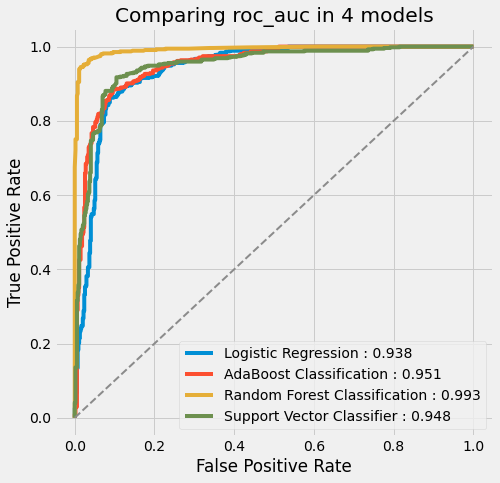

In [83]:
plt.figure(figsize=(7,7))
for score, name in zip(y_scores, model_names):
    roc_score = roc_auc_score(y_train_smote, score[:, 1])
    fpr, tpr, threshold = roc_curve(y_train_smote, score[:, 1])
    plt.plot(fpr, tpr, label=f"{name} : {round(roc_score, 3)}")
plt.legend()
plt.plot([0,1],[0,1], '--', linewidth=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparing roc_auc in 4 models')

In [47]:
rf = RandomForestClassifier(n_estimators=rf_best['n_estimators'], criterion=rf_best['criterion'], max_depth=rf_best['max_depth'], 
                                  random_state=123)
rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=20, random_state=123)

In [99]:
pd.DataFrame(confusion_matrix(y_test, rf.predict(X_test)), index=['No DM(actual)', 'DM(actual)'], 
            columns=['No DM(predicted)', 'DM(predicted)'])

,No DM(predicted),DM(predicted)
No DM(actual),136,1
DM(actual),5,48


Text(0.5, 1.0, 'Important features according to Random Forest')

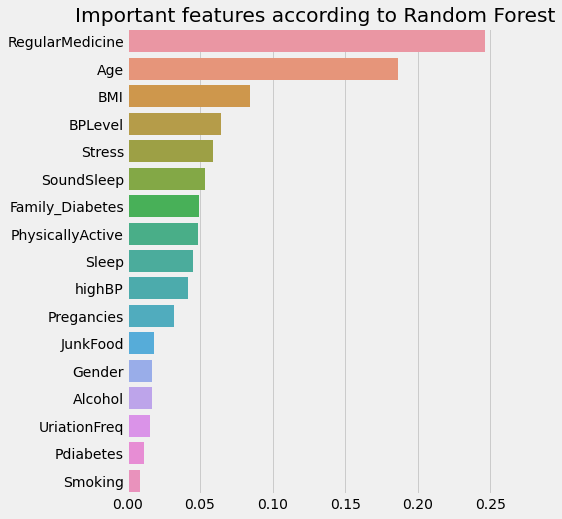

In [73]:
features = pd.Series(rf.feature_importances_, index=X_train_smote.columns).sort_values(ascending=False)
plt.figure(figsize=(6,8))
g = sns.barplot(features, features.index)
plt.title("Important features according to Random Forest");

In [125]:
#pickle.dump(rf, open('rf_model.sav', 'wb'))